# Load ModelNet10

In [212]:
import os
import numpy as np
import itertools
import math, random
random.seed = 42

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from pathlib import Path
import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [213]:
path = Path("./ModelNet10")

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes


{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

In [214]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces


def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
        layout=go.Layout(
            updatemenus=[dict(type='buttons',
                showactive=False,
                y=1,
                x=0.8,
                xanchor='left',
                yanchor='bottom',
                pad=dict(t=45, r=10),
                buttons=[dict(label='Play',
                    method='animate',
                    args=[None, dict(frame=dict(duration=50, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True,
                        mode='immediate'
                        )]
                    )
                ])]
        ),
        frames=frames
    )

    return fig


def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

In [271]:
with open(path/"bathtub/train/bathtub_0001.off", 'r') as f:
    verts, faces = read_off(f)
    
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T
len(x)


3514

In [273]:
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='yellowgreen', opacity=0.50, i=i,j=j,k=k)]).show()

In [275]:


pcshow(x,y,z)



In [276]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points

In [278]:
pointcloud = PointSampler(512)((verts, faces))
pcshow(*pointcloud.T)

In [279]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [281]:


norm_pointcloud = Normalize()(pointcloud)
pcshow(*norm_pointcloud.T)



In [282]:
type(norm_pointcloud)

numpy.ndarray

In [283]:
norm_pointcloud.shape

(512, 3)

In [284]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(256),
                                # Normalize(),
                                # ToTensor()
                              ])

In [285]:
train_transforms = transforms.Compose([
                                PointSampler(256),
                                # Normalize(),
])

In [286]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}
        # return np.concatenate(pointcloud, self.classes[category])

In [287]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [288]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [289]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].shape)
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  (256, 3)
Class:  bathtub


In [290]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

In [291]:
train_ds[3000]['category']

7

In [292]:
type(train_ds[0])

dict

In [293]:
train_ds[0]

{'pointcloud': array([[ 2.43750000e+01, -4.51006851e+01, -1.15412118e+01],
        [ 7.92575836e+00,  3.25592977e+01, -1.80191000e+01],
        [-2.43750000e+01, -3.30504924e+01,  9.33518323e+00],
        [ 2.43750000e+01,  2.64997939e+01, -7.57430995e+00],
        [ 3.72013914e+00,  3.66129146e+01, -1.22691000e+01],
        [ 1.20599797e+01,  3.58026220e+01, -1.22691000e+01],
        [ 1.67596233e+01,  4.76250000e+01, -8.39664749e+00],
        [-2.43750000e+01,  4.58199411e+01, -1.00226160e+01],
        [-2.43750000e+01, -1.24295348e+01,  6.67437410e+00],
        [-1.14581476e+01, -2.43179255e+01, -1.22691000e+01],
        [-2.43750000e+01,  1.26083776e+00, -1.24883242e+01],
        [ 1.30733091e+01,  2.99361727e+01, -1.80191000e+01],
        [-2.43750000e+01, -2.02597689e+01,  7.56470415e+00],
        [-2.28862623e+01,  4.76250000e+01,  2.51737064e+00],
        [-1.39792429e+01,  1.03109124e+01, -1.80191000e+01],
        [-1.85718001e+01, -1.40828942e+01,  1.19809000e+01],
        [ 

In [234]:
import pandas as pd

In [235]:
train_df = pd.json_normalize(train_ds[0])
valid_df = pd.json_normalize(valid_ds[0])
train_df

,pointcloud,category
0,"[[-23.182293235861607, 47.625, 3.0797919329288...",0


In [236]:
d = {}

i = 0


for entry in train_ds:

    # add a dictionary entry to the final dictionary
    d[i] = {"pointcloud": entry['pointcloud'], "category": entry['category']}
    
    # increment the counter
    i = i + 1
    # print(i)

train_df = pd.DataFrame.from_dict(d, 'index')

In [237]:
d = {}

i = 0


for entry in valid_ds:

    # add a dictionary entry to the final dictionary
    d[i] = {"pointcloud": entry['pointcloud'], "category": entry['category']}
    
    # increment the counter
    i = i + 1
    # print(i)

valid_df = pd.DataFrame.from_dict(d, 'index')

In [238]:
train_df.tail()

,pointcloud,category
3986,"[[-4.128626868923652, 1.6404968461197835, 4.01...",9
3987,"[[4.0321797228111524, -3.9282455953594204, 1.3...",9
3988,"[[2.7122799364630636, 8.205194676998183, 14.31...",9
3989,"[[156.58952564542042, -101.0321624293083, -35....",9
3990,"[[-1.8770897820721244, 15.34888714731186, -5.0...",9


In [297]:
pcshow(*valid_df['pointcloud'][0].T)

In [308]:
# train_df['pointcloud'][0]

In [316]:
x_train = np.stack(np.asarray(train_df['pointcloud']), axis=0)
# print(x_train.shape)
# x_train = x_train.reshape(3991, 256, 3)
x_train.shape

(3991, 256, 3)

In [311]:
# x_train[0]

In [317]:
pcshow(*x_train[0].T)

In [240]:
y_train = np.asarray(train_df['category'])
y_train.shape

(3991,)

In [319]:
x_test = np.stack(np.asarray(valid_df['pointcloud']), axis=0)
# x_test = x_test.reshape(908, 256, 3)
x_test.shape

(908, 256, 3)

In [320]:
y_test = np.asarray(valid_df['category'])
y_test.shape

(908,)

### One-hot encoding of labels

In [321]:
from sklearn.preprocessing import OneHotEncoder

one = OneHotEncoder()
y_test_one = one.fit_transform(y_test.reshape(-1,1))
y_train_one = one.fit_transform(y_train.reshape(-1,1))
y_train_one[-1].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

# Define persistance diagrams

In [322]:
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy
from gtda.plotting import plot_point_cloud


In [323]:
homology_dimensions = [0, 1, 2]


persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)
persistence_diagrams = persistence.fit_transform(x_train)

In [324]:
persistence_entropy = PersistenceEntropy(normalize=True)
# Calculate topological feature matrix
X = persistence_entropy.fit_transform(persistence_diagrams)
# Visualise feature matrix
# plot_point_cloud(X)

In [325]:
from gtda.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


In [326]:
rf = RandomForestClassifier(oob_score=True, random_state=42)

rf.fit(X, y_train)

X_test = persistence_entropy.fit_transform(persistence.fit_transform(x_test))
rf.score(X_test, y_test)


0.47026431718061673

In [327]:
rf.oob_score_

0.520922074668003

In [328]:
from gtda.plotting import plot_point_cloud
plot_point_cloud(X)

# Improving model

In [329]:
from gtda.diagrams import NumberOfPoints

# Reshape single diagram to (n_samples, n_features, 3) format
diagram = persistence_diagrams[0][None, :, :]
# Get number of points for (H0, H1, H2)
NumberOfPoints().fit_transform(diagram)

array([[255,  83,   7]])

In [330]:
from gtda.diagrams import Amplitude

Amplitude(metric='wasserstein').fit_transform(diagram)

array([[47.17569361, 11.67243189,  1.22882242]])

In [331]:
from sklearn.pipeline import make_union

# Select a variety of metrics to calculate amplitudes
metrics = [
    {"metric": metric}
    for metric in ["bottleneck", "wasserstein", "landscape", "persistence_image"]
]

# Concatenate to generate 3 + 3 + (4 x 3) = 18 topological features
feature_union = make_union(
    PersistenceEntropy(normalize=True),
    NumberOfPoints(n_jobs=-1),
    *[Amplitude(**metric, n_jobs=-1) for metric in metrics]
)

In [332]:
plot_point_cloud(x_train[5])
# x_train[0].shape

In [333]:
x_train_transformed = feature_union.fit_transform(persistence_diagrams)
x_test_transformed = feature_union.fit_transform(persistence.fit_transform(x_test))
print(x_train_transformed.shape)
print(x_test_transformed.shape)

(3991, 18)
(908, 18)


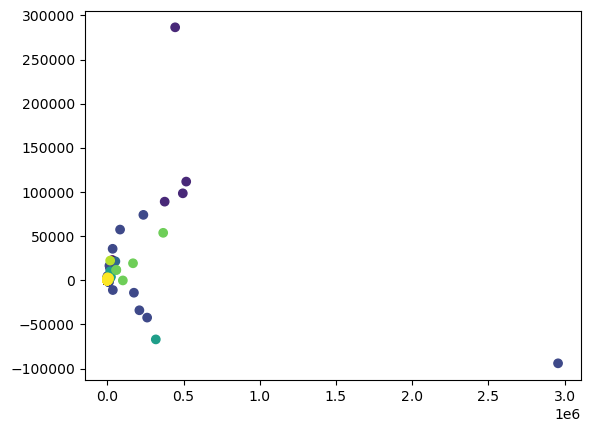

In [334]:
# Visualize training data
from sklearn.decomposition import PCA
pca = PCA()
Xt = pca.fit_transform(x_train_transformed)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y_train)
# plt.legend(handles=plot.legend_elements()[0], labels=y_train)
plt.show()

In [335]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

In [336]:
x_train_transformed_balanced, y_train_balanced = balanced_subsample(x_train_transformed, y_train)
x_test_transformed_balanced, y_test_balanced = balanced_subsample(x_test_transformed, y_test)

In [337]:
np.unique(y_test_balanced, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50]))

In [338]:
np.unique(y_train_balanced, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([106, 106, 106, 106, 106, 106, 106, 106, 106, 106]))

In [339]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

rfc.fit(x_train_transformed_balanced, y_train_balanced)

rfc.score(x_test_transformed_balanced, y_test_balanced)

0.576

In [340]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter = 10000, solver='adam', verbose=True, learning_rate='adaptive', activation='logistic')
# print(one.fit_transform(y_train_balanced).toarray().shape)
mlp.fit(x_train_transformed_balanced, y_train_balanced)

mlp.score(x_test_transformed_balanced, y_test_balanced)

Iteration 1, loss = 2.39555296
Iteration 2, loss = 2.30922396
Iteration 3, loss = 2.26722163
Iteration 4, loss = 2.24998452
Iteration 5, loss = 2.23596054
Iteration 6, loss = 2.22368237
Iteration 7, loss = 2.21139158
Iteration 8, loss = 2.20063479
Iteration 9, loss = 2.18366732
Iteration 10, loss = 2.16919943
Iteration 11, loss = 2.14914429
Iteration 12, loss = 2.13279977
Iteration 13, loss = 2.11252965
Iteration 14, loss = 2.09144179
Iteration 15, loss = 2.07083020
Iteration 16, loss = 2.05280878
Iteration 17, loss = 2.03465340
Iteration 18, loss = 2.01453469
Iteration 19, loss = 1.99342447
Iteration 20, loss = 1.97259930
Iteration 21, loss = 1.95318818
Iteration 22, loss = 1.93346235
Iteration 23, loss = 1.91597138
Iteration 24, loss = 1.89627023
Iteration 25, loss = 1.87545176
Iteration 26, loss = 1.85960780
Iteration 27, loss = 1.83880075
Iteration 28, loss = 1.82576746
Iteration 29, loss = 1.80895300
Iteration 30, loss = 1.79307539
Iteration 31, loss = 1.78362990
Iteration 32, los

0.596

In [343]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=80, algorithm='kd_tree')

knn.fit(x_train_transformed_balanced, y_train_balanced)

knn.score(x_test_transformed_balanced, y_test_balanced)

0.478

In [344]:
x_train.shape

(3991, 256, 3)

In [346]:
plot_point_cloud(x_train[5])

In [347]:
print(x_train_transformed_balanced[0])
print(x_test_transformed_balanced[0])

[7.53023681e-01 7.94300969e-01 1.00110646e+00 2.55000000e+02
 8.30000000e+01 7.00000000e+00 6.08141947e+00 5.28579998e+00
 8.51611137e-01 4.71756936e+01 1.16724319e+01 1.22882242e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.30021690e-01
 3.24604574e-01 8.77504953e-02]
[ 8.20658420e-01  7.85016770e-01 -1.53778339e+00  2.55000000e+02
  5.70000000e+01  4.00000000e+00  3.61429572e+00  4.48071003e+00
  2.50820160e-01  2.59317759e+01  8.41276459e+00  2.53673342e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.47351343e+00
  7.32172227e-01  9.63977494e-02]


In [348]:
from gtda.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline(
    [
        ("features", feature_union),
        ("rf", RandomForestClassifier(oob_score=True, random_state=42, n_estimators=1000)),
    ]
)
pipe.fit(persistence_diagrams, y_train)
pipe["rf"].oob_score_

0.6031069907291405

In [349]:
pipe.score(persistence.fit_transform(x_test), y_test)

/home/dijor/.local/lib/python3.10/site-packages/sklearn/utils/metaestimators.py:121: FutureWarning:

if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.



0.5704845814977973

In [350]:

pipe = Pipeline(
    [
        ("features", feature_union),
        ("mlp", MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)),
    ]
)
pipe.fit(persistence_diagrams, y_train)
# pipe["rf"].oob_score_

Iteration 1, loss = 33.82782534
Iteration 2, loss = 8.37585831
Iteration 3, loss = 6.59591493
Iteration 4, loss = 5.72270479
Iteration 5, loss = 4.99401547
Iteration 6, loss = 4.37005258
Iteration 7, loss = 4.07530077
Iteration 8, loss = 3.90588542
Iteration 9, loss = 3.83283114
Iteration 10, loss = 3.67461086
Iteration 11, loss = 3.66063229
Iteration 12, loss = 3.59674784
Iteration 13, loss = 3.47487083
Iteration 14, loss = 3.62009030
Iteration 15, loss = 3.52703871
Iteration 16, loss = 3.45438163
Iteration 17, loss = 3.25695672
Iteration 18, loss = 3.34687147
Iteration 19, loss = 3.22384623
Iteration 20, loss = 3.07000108
Iteration 21, loss = 3.12661541
Iteration 22, loss = 3.29820162
Iteration 23, loss = 3.31027079
Iteration 24, loss = 3.03924540
Iteration 25, loss = 3.05022223
Iteration 26, loss = 3.06846587
Iteration 27, loss = 3.39300879
Iteration 28, loss = 3.37892839
Iteration 29, loss = 3.14196332
Iteration 30, loss = 3.10843633
Iteration 31, loss = 2.99636464
Iteration 32, lo

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                 PersistenceEntropy(normalize=True)),
                                                ('numberofpoints',
                                                 NumberOfPoints(n_jobs=-1)),
                                                ('amplitude-1',
                                                 Amplitude(metric='bottleneck',
                                                           n_jobs=-1)),
                                                ('amplitude-2',
                                                 Amplitude(metric='wasserstein',
                                                           n_jobs=-1)),
                                                ('amplitude-3',
                                                 Amplitude(n_jobs=-1)),
                                                ('amplitude-4',
                                                 Amplitude(metric='persistence_image',
                                                           n_jobs=-1))])),
                ('mlp', MLPClassifier(max_iter=2000, verbose=True))])